# Quantum Random Access Optimization


In [20]:
from qiskit_optimization.algorithms.qrao import (
    QuantumRandomAccessEncoding,
    SemideterministicRounding,
    QuantumRandomAccessOptimizer,
)
import networkx as nx
from qiskit_optimization.applications import Maxcut

## Set up a combinatorial optimization problem

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_3*x_4 - 2*x_3*x_5
  - 2*x_4*x_5 + 2*x_0 + 2*x_1 + 3*x_2 + 3*x_3 + 2*x_4 + 2*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



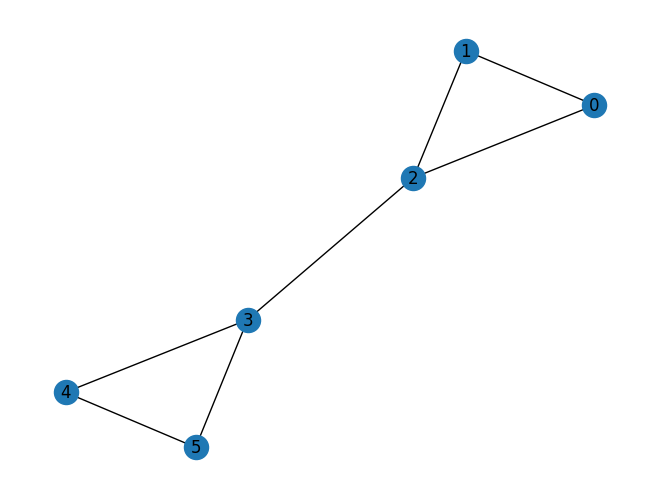

In [21]:
num_nodes = 6



# G = nx.random_regular_graph(d=3, n=num_nodes, seed=seed)
# nx.draw(G, with_labels=True, pos=nx.spring_layout(G, seed=seed))


G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,0),(3,2),(4,3),(5,3),(4,5)])
nx.draw_spring(G, with_labels=True)
maxcut = Maxcut(G)
problem = maxcut.to_quadratic_program()
print(problem.prettyprint())

## Encode the problem into a quantum hamiltonian

In [22]:
from qiskit_optimization.algorithms.qrao import QuantumRandomAccessEncoding


# Create an encoding object with a maximum of 3 variables per qubit, aka a (3,1,p)-QRAC
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)

# Encode the QUBO problem into an encoded Hamiltonian
encoding.encode(problem)

# This is our encoded Hamiltonian
print(f"Our encoded Hamiltonian is:\n( {encoding.qubit_op} ).\n")
print(
    "We achieve a compression ratio of "
    f"({encoding.num_vars} binary variables : {encoding.num_qubits} qubits) "
    f"≈ {encoding.compression_ratio}.\n"
)

Our encoded Hamiltonian is:
( SparsePauliOp(['IXX', 'XXI', 'XIX', 'XYI', 'YYI', 'IYY', 'YIY'],
              coeffs=[1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j]) ).

We achieve a compression ratio of (6 binary variables : 3 qubits) ≈ 2.0.



## Solve the problem using the `QuantumRandomAccessOptimizer`

In [23]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator

from qiskit_optimization.algorithms.qrao import (
    QuantumRandomAccessOptimizer,
    SemideterministicRounding,
)


# Prepare the VQE algorithm

ansatz = RealAmplitudes(2,reps=1)
vqe = VQE(
    ansatz=ansatz,
    optimizer=COBYLA(),
    estimator=Estimator(),
)



# Use semi-deterministic rounding, known as "Pauli rounding"
# in https://arxiv.org/pdf/2111.03167v2.pdf
# (This is the default if no rounding scheme is specified.)
semidterministic_rounding = SemideterministicRounding()

# Construct the optimizer
qrao = QuantumRandomAccessOptimizer(min_eigen_solver=vqe, rounding_scheme=semidterministic_rounding)

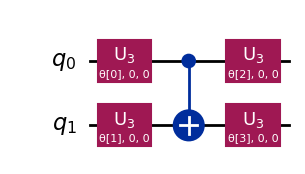

In [24]:
ansatz.decompose(reps=3).draw(output='mpl',style='iqp')

In [25]:
ansatz.num_parameters

4

In [26]:
# Solve the optimization problem
results = qrao.solve(problem)

print(
    f"The objective function value: {results.fval}\n"
    f"x: {results.x}\n"
    f"relaxed function value: {-1 * results.relaxed_fval}\n"
)

The objective function value: 5.0
x: [0 1 0 1 0 1]
relaxed function value: 6.499999984658062



In [27]:
from qiskit_algorithms import NumPyMinimumEigensolver

from qiskit_optimization.algorithms import MinimumEigenOptimizer

exact_mes = NumPyMinimumEigensolver()
exact = MinimumEigenOptimizer(exact_mes)
exact_result = exact.solve(problem)
print(exact_result.prettyprint())



objective function value: 5.0
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=1.0, x_5=0.0
status: SUCCESS


In [28]:
print("QRAO Approximate Optimal Function Value:", results.fval)
print("Exact Optimal Function Value:", exact_result.fval)
print(f"Approximation Ratio: {results.fval /  exact_result.fval :.2f}")

QRAO Approximate Optimal Function Value: 5.0
Exact Optimal Function Value: 5.0
Approximation Ratio: 1.00


## Interpret the solution

The obtained solution places a partition between nodes [1] and nodes [0, 2, 3, 4, 5].


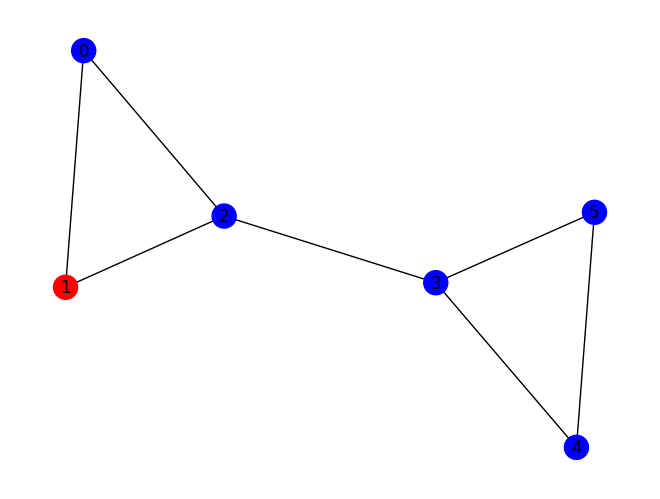

In [8]:
maxcut_partition = maxcut.interpret(results)
print(
    f"The obtained solution places a partition between nodes {maxcut_partition[0]} "
    f"and nodes {maxcut_partition[1]}."
)
maxcut.draw(results, pos=nx.spring_layout(G, seed=1))



## Inspect the results

In [9]:
results.samples



[SolutionSample(x=array([1, 0, 1, 1, 1, 1], dtype=int64), fval=2.0, probability=1.0, status=<OptimizationResultStatus.SUCCESS: 0>)]

# Alternative Way

## Manually Solce the relaxed problem

In [10]:
# Encode the QUBO problem into a relaxed Hamiltonian
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)
encoding.encode(problem)

# Solve the relaxed problem
relaxed_results, rounding_context = qrao.solve_relaxed(encoding)



In [11]:
for k in dir(relaxed_results):
    if not k.startswith("_"):
        print(f"{k}: {getattr(relaxed_results, k)}")



aux_operators_evaluated: [(-0.21110397735519407, {}), (0.20505361714260034, {}), (-0.26684667452345145, {}), (0.0, {}), (0.0, {}), (0.0, {})]
combine: <bound method AlgorithmResult.combine of <qiskit_algorithms.minimum_eigensolvers.vqe.VQEResult object at 0x0000019516180460>>
cost_function_evals: 186
eigenvalue: -2.9999999795196834
optimal_circuit:      »
q_0: »
     »
q_1: »
     »
q_2: »
     »
«     ┌────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                               ├
«     │                                                                                │
«q_1: ┤1 RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11]) ├
«     │                                                                                │
«q_2: ┤2                                                                               ├
«     └───────────────────────────────────────────────────────────

## Manually perform rounding

In [12]:
# Round the relaxed solution using semi-deterministic rounding
semidterministic_rounding = SemideterministicRounding()
sdr_results = semidterministic_rounding.round(rounding_context)
qrao_results_sdr = qrao.process_result(
    problem=problem, encoding=encoding, relaxed_result=relaxed_results, rounding_result=sdr_results
)

print(
    f"The objective function value: {qrao_results_sdr.fval}\n"
    f"x: {qrao_results_sdr.x}\n"
    f"relaxed function value: {-1 * qrao_results_sdr.relaxed_fval}\n"
    f"The number of distinct samples is {len(qrao_results_sdr.samples)}."
)

The objective function value: 3.0
x: [1 0 1 0 0 0]
relaxed function value: -6.499999979519684
The number of distinct samples is 1.


# Appendix

## Verify Correctness

In [14]:
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)
encoding.encode(problem)

print("Encoded Problem:\n=================")
print(encoding.qubit_op)  # The Hamiltonian without the offset
print("Offset = ", encoding.offset)
print("Variables encoded on each qubit: ", encoding.q2vars)

Encoded Problem:
SparsePauliOp(['IXX', 'XXI', 'XIX', 'XYI', 'YYI', 'IYY', 'YIY'],
              coeffs=[1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j])
Offset =  -3.5
Variables encoded on each qubit:  [[2, 4], [0, 3], [1, 5]]


In [15]:
import numpy as np
from qiskit_optimization.algorithms.qrao import EncodingCommutationVerifier
verifier = EncodingCommutationVerifier(encoding, estimator=Estimator())
if not len(verifier) == 2**encoding.num_vars:
    print("The number results of the encoded problem is not equal to 2 ** num_vars.")

for str_dvars, obj_val, encoded_obj_val in verifier:
    if not np.isclose(obj_val, encoded_obj_val):
        print(
            f"Violation identified: {str_dvars} evaluates to {obj_val} "
            f"but the encoded problem evaluates to {encoded_obj_val}."
        )